# Solutions to Exercises

# GPU in colab
First, you'll need to enable GPUs for the notebook:
*   Navigate to Edit→Notebook Settings
*   select GPU from the Hardware Accelerator drop-down




In [ ]:
%tensorflow_version 2.x

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


2022-05-11 18:16:06.996272: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-11 18:16:07.059423: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-11 18:16:07.107211: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-11 18:16:07.107371: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [ ]:
from google.colab import drive, files

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

# Exercise 1

a) Load and preprocess CIFAR10 Dataset.


In [ ]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [ ]:
X_train.shape, y_train.shape, X_train.shape, y_test.shape

((50000, 32, 32, 3), (50000, 1), (50000, 32, 32, 3), (10000, 1))

In [ ]:
numb_cats = y_train.max() + 1 # number of different categories

In [ ]:
y_train = tf.keras.utils.to_categorical(y_train, numb_cats) # converting to vector of probabilities
y_test =  tf.keras.utils.to_categorical(y_test, numb_cats)

In [ ]:
X_train.max(), X_train.min() # checking if images are rescaled

(255, 0)

In [ ]:
datagen = ImageDataGenerator(
    rescale=1./255, # rescaling 
    featurewise_center=True, # if True it sets the mean to 0
    featurewise_std_normalization=True, # if True sets stdev to 1
    validation_split=0.2# float fraction of images for validation
    )

# other patemeters of ImageDataGenerator are found here:
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

BATCH_SIZE = 64 # mini batch size

datagen.fit(X_train) # preprocessing data by applying the generator to our train dataset
datagen.fit(X_test) # applying the generator to our train dataset




In [ ]:
train_dataset = datagen.flow(
    X_train, # Selecting X train
    y_train, # Selecting target
    batch_size=BATCH_SIZE, # Specifying the size of mini-batch
    shuffle=True, # if True it shuffles the data randomly
    subset='training' # Picks the training subset of the data 
    #so 1 - validation_split fraction of dataset
    )

val_dataset = datagen.flow(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    subset='validation'
    )

test_dataset =  datagen.flow(
    X_test,
    y_test,
    batch_size=1 # with test data batch size should be 1
    )

b) Set up the LeNet5 Model with the following modifications
- Increase the number of filters by a factor of 4
- Make the kernel size (3, 3)
- Use ReLu activation function, 
- Add Dropout Layer
- Replace  AveragePooling with MaxPooling replacing


In [ ]:
input_shape = X_train.shape[1:]
input_shape

(32, 32, 3)

In [ ]:
model = tf.keras.Sequential()
## MAGIC LAYERS will be explained next week #########
# C1 layer
model.add(tf.keras.layers.Conv2D(
    filters=6*4,
    kernel_size=(3, 3),
    activation='relu',
    input_shape=input_shape)
)
# S2 Layer
model.add(tf.keras.layers.MaxPooling2D((2, 2))) # this performs downsampling 
# C3 layer
model.add(tf.keras.layers.Conv2D(
    filters=16*4,
    kernel_size=(3, 3),
    activation='relu',
    input_shape=input_shape)
)
# S4 Layer
model.add(tf.keras.layers.MaxPooling2D((2, 2))) # this performs downsampling 
# C5 layer
model.add(tf.keras.layers.Flatten()) # flattening 
model.add(tf.keras.layers.Dense(120, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
# F6 
model.add(tf.keras.layers.Dense(84, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(numb_cats, activation='softmax')) # output layer

c) Set up the callbacks


In [ ]:
# saving best model

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "model.h5", 
    monitor = "val_accuracy", 
    verbose = 1, 
    save_best_only = True,
    mode = 'max'
    )


In [ ]:
# early stopping - prevents overstopping, lr_scheduler, tensorboard_callback]fitting
# it stops the training if your model stops improving for specified number of epochs
earlystopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', # we monitor the loss for the validation 
    min_delta=0, # minimum change in the monitored quantity to qualify as an improvement
    patience=5, # Number of epochs with no improvement after which training will be stopped.
    verbose=1, # how verbal the description should be
    mode='min', # In min mode, training will stop when the quantity monitored has stopped decreasing
    baseline=None, # Baseline value for the monitored quantity. Training will stop if the model doesn't show improvement over the baseline.
    restore_best_weights=False # Whether to restore model weights from the epoch with the best value of the monitored quantity. If False, the model weights obtained at the last step of training are used.
)




In [ ]:
# At the beginning of every epoch, 
# this callback gets the updated learning rate value 
# from scheduler function 

def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_scheduler= tf.keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
# TensorBoard is a visualization tool provided with TensorFlow.
# This callback logs events for TensorBoard, including:
# Metrics summary plots
# Training graph visualization
# Weight histograms
# Sampled profiling

logdir = "../logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)


In [ ]:
# collecting all callbacks together

callbacks_list = [checkpoint, earlystopping, lr_scheduler, tensorboard_callback]

## Optimizer & Compliing the model

d) Compile the model and fit the data to the model


In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=["accuracy"])

In [ ]:
EPOCHS = 15

In [ ]:
history = model.fit(
    train_dataset,
    steps_per_epoch=train_dataset.n // BATCH_SIZE,
    validation_data=val_dataset,
    validation_steps=val_dataset.n // BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks_list
    )

Epoch 1/15
623/625 [============================>.] - ETA: 0s - loss: 1.8101 - accuracy: 0.3247
Epoch 00001: val_accuracy improved from -inf to 0.50080, saving model to model.h5
625/625 [==============================] - 2s 2ms/step - loss: 1.8088 - accuracy: 0.3252 - val_loss: 1.3912 - val_accuracy: 0.5008 - lr: 0.0010
Epoch 2/15
619/625 [============================>.] - ETA: 0s - loss: 1.4314 - accuracy: 0.4849
Epoch 00002: val_accuracy improved from 0.50080 to 0.58834, saving model to model.h5
625/625 [==============================] - 1s 2ms/step - loss: 1.4299 - accuracy: 0.4857 - val_loss: 1.1572 - val_accuracy: 0.5883 - lr: 0.0010
Epoch 3/15
602/625 [===========================>..] - ETA: 0s - loss: 1.2726 - accuracy: 0.5507
Epoch 00003: val_accuracy improved from 0.58834 to 0.62961, saving model to model.h5
625/625 [==============================] - 1s 2ms/step - loss: 1.2718 - accuracy: 0.5515 - val_loss: 1.0719 - val_accuracy: 0.6296 - lr: 0.0010
Epoch 4/15
611/625 [========

e) Plot the accuracy and loss curves, also view it on tensorboard. 

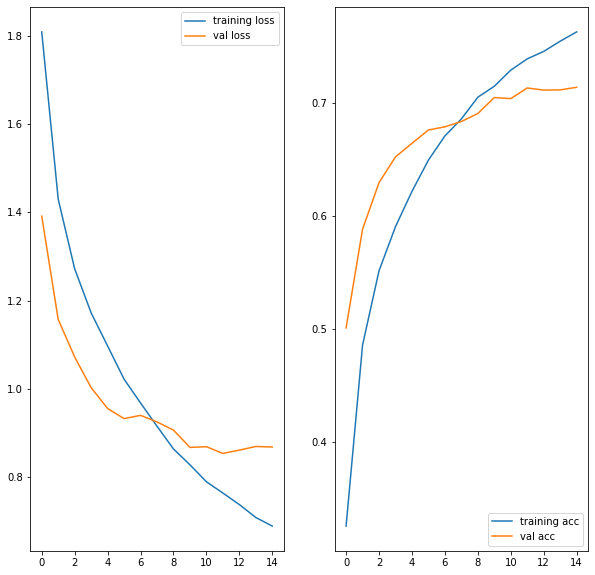

In [ ]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label="training loss")
plt.plot(history.history['val_loss'], label="val loss")
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label="training acc")
plt.plot(history.history['val_accuracy'], label="val acc")
plt.legend(loc='lower right')

plt.show()

In [ ]:
%load_ext tensorboard
%tensorboard --logdir ../logs/scalars

f)  Load the best saved model


In [ ]:
# loading the best weights
model.load_weights("model.h5")

g) Evaluate the model on the test data and compare your scores with the GUIDE notebook. 


In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)
print(f'Test accuracy: {test_acc}, test loss: {test_loss}')

10000/10000 [==============================] - 11s 1ms/step - loss: 0.8875 - accuracy: 0.7083
Test accuracy: 0.708299994468689, test loss: 0.887546181678772


# Exercise 2




1. From https://keras.io/api/applications/ pick a network with the smallest number of patemters. 
2. Set it up for transer-learning (all layers of this network should be frozen) for the cifar10 dataset. 
3. Fit the network and evaluate the model on the test data.

You should further experiment with the networks and vary the parameters, unfreeze the layers etc. 

In [ ]:
res_net_img_size  = (224,)
base_model = tf.keras.applications.MobileNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=2*res_net_img_size  + (3,),
    pooling=None,
    classifier_activation="softmax",
)

9420800/9406464 [==============================] - 1s 0us/step


In [ ]:
base_model.trainable = False

In [ ]:
tl_model = tf.keras.Sequential()
tl_model.add(tf.keras.layers.Resizing(res_net_img_size[0], res_net_img_size[0]))
tl_model.add(base_model)
tl_model.add(tf.keras.layers.Flatten()) # flattening 
# Batch normalization applies a transformation that maintains the mean output 
# close to 0 and the output standard deviation close to 1.
tl_model.add(tf.keras.layers.BatchNormalization())
tl_model.add(tf.keras.layers.Dense(1024, activation="relu"))
tl_model.add(tf.keras.layers.Dropout(0.3))
tl_model.add(tf.keras.layers.BatchNormalization())
tl_model.add(tf.keras.layers.Dense(128, activation="relu"))
tl_model.add(tf.keras.layers.Dropout(0.3))
tl_model.add(tf.keras.layers.Dense(numb_cats, activation='softmax')) # output layer

In [ ]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6)
tl_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=["accuracy"])

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "tl_model.h5", 
    monitor = "val_accuracy", 
    verbose = 1, 
    save_best_only = True,
    mode = 'max'
    )

callbacks_list = [checkpoint]

In [ ]:
EPOCHS = 2

In [ ]:
history = tl_model.fit(
    train_dataset,
    steps_per_epoch=train_dataset.n // BATCH_SIZE,
    validation_data=val_dataset,
    validation_steps=val_dataset.n // BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks_list
    )

Epoch 1/2
625/625 [==============================] - ETA: 0s - loss: 0.8393 - accuracy: 0.7345
Epoch 00001: val_accuracy improved from -inf to 0.82332, saving model to tl_model.h5


/home/gnacikm/VEnvs/vowel-rec/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
2022-05-11 18:24:05.587385: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 256901120 exceeds 10% of free system memory.
2022-05-11 18:24:06.171390: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 256901120 exceeds 10% of free system memory.


625/625 [==============================] - 46s 71ms/step - loss: 0.8393 - accuracy: 0.7345 - val_loss: 0.5499 - val_accuracy: 0.8233
Epoch 2/2
625/625 [==============================] - ETA: 0s - loss: 0.3927 - accuracy: 0.8694
Epoch 00002: val_accuracy improved from 0.82332 to 0.83734, saving model to tl_model.h5


2022-05-11 18:24:48.350191: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 256901120 exceeds 10% of free system memory.


625/625 [==============================] - 43s 69ms/step - loss: 0.3927 - accuracy: 0.8694 - val_loss: 0.5396 - val_accuracy: 0.8373


In [ ]:
test_loss, test_acc = tl_model.evaluate(test_dataset)
print(f'Test accuracy: {test_acc}, test loss: {test_loss}')

10000/10000 [==============================] - 67s 7ms/step - loss: 0.5609 - accuracy: 0.8304
Test accuracy: 0.8303999900817871, test loss: 0.5608578324317932
